In [133]:
#pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 4.0 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import temporal modules needed for testing plotting
import matplotlib.pyplot as plt
import numpy as np
import os 
from datetime import datetime


%matplotlib inline


In [3]:
# Extract results arrays

# Define the path to the parent directory
parent_dir = '/home/jovyan/experiment_data/2022-2023_48h_experiment/batch_output'

In [4]:
save_dir = '/home/jovyan/experiment_data/2022-2023_48h_experiment/batch_output/analysis_plots'
def save_plot(save_dir, name):
    save_path = os.path.join(save_dir, f"{name}.png")
    fig.savefig(save_path, dpi=300, bbox_inches='tight')

## 1. Analysis of error of distortion (corr, hes, ssmi) of SAR forecast

In [5]:
def export_pm_output_data(parent_dir, vars_folder_name, variable_names):
    """
    Extracts pattern matching output variables from .npz files in subdirectories of a parent directory.
    
    Args:
    parent_dir (str): The path to the parent directory containing subdirectories.
    vars_folder_name (str): The name of the folder within each subdirectory that contains the .npz file.
    **kwargs: Keyword arguments specifying the variable names to extract from the .npz files.
    
    The possible key variables to extract and their descriptions are:
    - upm: Eastward ice drift displacement in destination SRS units.
    - vpm: Northward ice drift displacement in destination SRS units.
    - apm: Angle that gives the highest MCC (Maximum Cross Correlation).
    - rpm: Maximum cross correlation (MCC) value.
    - hpm: Hessian of the cross-correlation at the MCC point.
    - ssim: Similarity index between the two images for each point.
    - lon2pm: Longitude of results on image 2.
    - lat2pm: Latitude of results on image 2.
    - gpi1: Mask of good pixels after filtering with the hessian.
    - gpi2: Mask of good pixels after filtering with the hessian and number of neighboring pixels.
    - model_u - Eastward model ice drift displacement in destination SRS units.
    - model_v - Northward model ice drift displacement in destination SRS units.
    
    Returns:
    dict: A dictionary containing lists of extracted data for each specified variable.
    list: A list of timestamps extracted from the folder names.
    """
    
    # Initialize a dictionary to hold lists for each variable
    data_dict = {var: [] for var in variable_names}
    timestamps = []

    # Iterate through subdirectories (folders for each pair)
    for subdir in os.listdir(parent_dir):
        sub_dir_path = os.path.join(parent_dir, subdir)

        # Check if the .npz file exists
        npz_file_path = os.path.join(sub_dir_path, vars_folder_name, f'{vars_folder_name}.npz')
        if os.path.exists(npz_file_path):
            # Load the contents of the .npz file
            npz_data = np.load(npz_file_path)

            # Extract and append parameters to their respective lists in the dictionary
            for var in variable_names:
                if var in npz_data:
                    data_dict[var].append(npz_data[var])

            # Extract and append the timestamps from folder names
            timestamps.append(subdir)

    # Return the dictionary and the timestamps
    return data_dict, timestamps


def calculate_mean_distor_parameters(timestamps, rpm_list, hpm_list, ssim_list, gpi_list=None):
    """
    Calculates the mean, minimum, and maximum values for various distortion parameters 
    for each timestamp and optionally filters the data based on a good pixel index list.

    Parameters:
    timestamps (list): List of timestamps corresponding to each set of data.
    rpm_list (list): List of RPM (Maximum Cross Correlation) values for each timestamp.
    hpm_list (list): List of HPM (Hessian of Cross-Correlation at MCC point) values for each timestamp.
    ssim_list (list): List of SSIM (Similarity Index) values for each timestamp.
    gpi_list (list, optional): List of good pixel index masks to filter the data. 
                               If None, no filtering is applied.

    Returns:
    dict: A dictionary containing the following keys and their corresponding list of values:
        - 'rpm_mean': Mean values of RPM.
        - 'rpm_min': Minimum values of RPM.
        - 'rpm_max': Maximum values of RPM.
        - 'hpm_mean': Mean values of HPM.
        - 'hpm_min': Minimum values of HPM.
        - 'hpm_max': Maximum values of HPM.
        - 'ssim_mean': Mean values of SSIM.
        - 'ssim_min': Minimum values of SSIM.
        - 'ssim_max': Maximum values of SSIM.
    
    Each key in the dictionary corresponds to a specific statistic (mean, min, max) for each parameter (RPM, HPM, SSIM).
    """
    
    # Initialize a dictionary to store statistics for each parameter
    statistics = {
        'rpm_mean': [], 'rpm_min': [], 'rpm_max': [],
        'hpm_mean': [], 'hpm_min': [], 'hpm_max': [],
        'ssim_mean': [], 'ssim_min': [], 'ssim_max': []
    }

    # Iterate through the pairs and calculate statistics
    for i in range(len(timestamps)):
        # Determine data based on whether gpi_list is defined
        rpm_data = rpm_list[i] if gpi_list is None else rpm_list[i][gpi_list[i]]
        hpm_data = hpm_list[i] if gpi_list is None else hpm_list[i][gpi_list[i]]
        ssim_data = ssim_list[i] if gpi_list is None else ssim_list[i][gpi_list[i]]

        # Calculate and append statistics for RPM, HPM, and SSIM
        for param, data in zip(['rpm', 'hpm', 'ssim'], [rpm_data, hpm_data, ssim_data]):
            mean = round(np.nanmean(data), 2)
            min_val = round(np.nanmin(data), 2)
            max_val = round(np.nanmax(data), 2)

            statistics[f'{param}_mean'].append(mean)
            statistics[f'{param}_min'].append(min_val)
            statistics[f'{param}_max'].append(max_val)

        # Print the calculated statistics for the current pair
        print(f"Pair {i + 1}:")
        print(f"RPM Mean: {statistics['rpm_mean'][-1]}, Min: {statistics['rpm_min'][-1]}, Max: {statistics['rpm_max'][-1]}")
        print(f"HPM Mean: {statistics['hpm_mean'][-1]}, Min: {statistics['hpm_min'][-1]}, Max: {statistics['hpm_max'][-1]}")
        print(f"SSIM Mean: {statistics['ssim_mean'][-1]}, Min: {statistics['ssim_min'][-1]}, Max: {statistics['ssim_max'][-1]}")
        print("-" * 20)

    return statistics




In [6]:
# Exporting drift parametrs (between SAR1 and SAR2)
sar_drift_folder_name = 'sar_drift_output'
drift_variable_names = ['upm', 'vpm', 'rpm', 'hpm', 'gpi2' ]
sar_drift_data, timestamps = export_pm_output_data(parent_dir, sar_drift_folder_name, drift_variable_names)


u_sar_list = sar_drift_data['upm']
v_sar_list = sar_drift_data['vpm']
sar12_rpm_list = sar_drift_data['rpm']
sar12_hpm_list = sar_drift_data['hpm']
gpi2_list = sar_drift_data['gpi2']
timestamps

['20221120T080155_20221122T074535',
 '20221207T081027_20221209T075358',
 '20221226T080153_20221228T074533',
 '20230107T080152_20230109T074532',
 '20230119T080151_20230121T074532',
 '20230210T081814_20230212T080151',
 '20230212T080151_20230214T074531',
 '20230320T080151_20230322T074531',
 '20230327T075355_20230329T073729']

In [7]:
# Exporting distortion parametrs (between SAR2 real and SAR2 predictions)
sar_distor_folder_name = 'sar_distort_error_data'
distor_variable_names = ['rpm', 'hpm', 'ssim']
sar_distor_data, timestamps = export_pm_output_data(parent_dir, sar_distor_folder_name, distor_variable_names)
    
sar_rpm_list = sar_distor_data['rpm']
sar_hpm_list = sar_distor_data['hpm']
sar_ssim_list = sar_distor_data['ssim']

In [8]:
sar_distor_statistics = calculate_mean_distor_parameters(timestamps, sar_rpm_list, sar_hpm_list, sar_ssim_list, gpi2_list)

rpm_mean_values = sar_distor_statistics['rpm_mean']
sar_rpm_mean = sar_distor_statistics['rpm_mean']
sar_rpm_min = sar_distor_statistics['rpm_min']
sar_rpm_max = sar_distor_statistics['rpm_max']
sar_hpm_mean = sar_distor_statistics['hpm_mean']
sar_hpm_min = sar_distor_statistics['hpm_min']
sar_hpm_max = sar_distor_statistics['hpm_max']
sar_ssim_mean = sar_distor_statistics['ssim_mean']
sar_ssim_min = sar_distor_statistics['ssim_min']
sar_ssim_max = sar_distor_statistics['ssim_max']

Pair 1:
RPM Mean: 0.56, Min: 0.2, Max: 0.92
HPM Mean: 15.29, Min: -0.24, Max: 31.92
SSIM Mean: 0.4, Min: 0.01, Max: 0.89
--------------------
Pair 2:
RPM Mean: 0.58, Min: 0.21, Max: 0.9
HPM Mean: 13.93, Min: -0.49, Max: 32.88
SSIM Mean: 0.37, Min: 0.01, Max: 0.77
--------------------
Pair 3:
RPM Mean: 0.49, Min: 0.2, Max: 0.88
HPM Mean: 12.75, Min: -0.94, Max: 30.31
SSIM Mean: 0.34, Min: 0.03, Max: 0.78
--------------------
Pair 4:
RPM Mean: 0.47, Min: 0.17, Max: 1.0
HPM Mean: 12.23, Min: -0.33, Max: 29.48
SSIM Mean: 0.33, Min: 0.0, Max: 0.79
--------------------
Pair 5:
RPM Mean: 0.45, Min: 0.19, Max: 0.97
HPM Mean: 11.87, Min: 0.12, Max: 29.69
SSIM Mean: 0.32, Min: 0.01, Max: 0.97
--------------------
Pair 6:
RPM Mean: 0.49, Min: 0.19, Max: 0.85
HPM Mean: 14.15, Min: 0.62, Max: 27.68
SSIM Mean: 0.36, Min: 0.08, Max: 0.67
--------------------
Pair 7:
RPM Mean: 0.51, Min: 0.17, Max: 0.84
HPM Mean: 15.08, Min: -0.26, Max: 28.93
SSIM Mean: 0.38, Min: 0.0, Max: 0.72
--------------------
P

In [34]:
'''
# of quality parameters from output folder
# Initialize lists to store parameters and timestamps
def export_distort_data(parent_dir, vars_folder_name):
    rpm_list = []
    hpm_list = []
    ssim_list = []
    lon2pm_list = []
    lat2pm_list = []
    timestamps = []

    gpi1_list = []
    gpi2_list = []

    # Iterate through subdirectories (folders for each pair)
    for subdir in os.listdir(parent_dir):
        sub_dir_path = os.path.join(parent_dir, subdir)

        # Check if the 'sar_drift_forecast_quality.npz' file exists
        npz_file_path = os.path.join(sub_dir_path, vars_folder_name, f'{vars_folder_name}.npz')
        if os.path.exists(npz_file_path):
            # Load the contents of the .npz file
            npz_data = np.load(npz_file_path)

            # Extract and append parameters to their respective lists
            rpm_list.append(npz_data['rpm'])
            hpm_list.append(npz_data['hpm'])
            ssim_list.append(npz_data['ssim'])
            lon2pm_list.append(npz_data['lon2pm'])
            lat2pm_list.append(npz_data['lat2pm'])
            gpi1_list.append(npz_data['gpi1'])
            gpi2_list.append(npz_data['gpi2'])

            # Extract and append the timestamps from folder names
            timestamps.append(subdir)
    return rpm_list, hpm_list, ssim_list, lon2pm_list, lat2pm_list, gpi1_list, gpi2_list, timestamps

# Assuming you have the lists rpm_list, hpm_list, ssim_list, and timestamps

def calculate_mean_distor_parameters(timestamps, rpm_list, hpm_list, ssim_list, gpi_list=None):
    # Initialize lists to store mean, min, and max values for each parameter
    rpm_mean_values = []
    rpm_min_values = []
    rpm_max_values = []

    hpm_mean_values = []
    hpm_min_values = []
    hpm_max_values = []

    ssim_mean_values = []
    ssim_min_values = []
    ssim_max_values = []

    # Iterate through the pairs and calculate statistics
    for i in range(len(timestamps)):
        # Determine data based on whether gpi_list is defined
        rpm_data = rpm_list[i] if gpi_list is None else rpm_list[i][gpi_list[i]]
        hpm_data = hpm_list[i] if gpi_list is None else hpm_list[i][gpi_list[i]]
        ssim_data = ssim_list[i] if gpi_list is None else ssim_list[i][gpi_list[i]]

        # Calculate mean, min, and max values for RPM
        rpm_mean = round(np.nanmean(rpm_data), 2)
        rpm_min = round(np.nanmin(rpm_data), 2)
        rpm_max = round(np.nanmax(rpm_data), 2)

        # Append values to respective lists
        rpm_mean_values.append(rpm_mean)
        rpm_min_values.append(rpm_min)
        rpm_max_values.append(rpm_max)

        # Calculate mean, min, and max values for HPM
        hpm_mean = round(np.nanmean(hpm_data), 2)
        hpm_min = round(np.nanmin(hpm_data), 2)
        hpm_max = round(np.nanmax(hpm_data), 2)

        # Append values to respective lists
        hpm_mean_values.append(hpm_mean)
        hpm_min_values.append(hpm_min)
        hpm_max_values.append(hpm_max)

        # Calculate mean, min, and max values for SSIM
        ssim_mean = round(np.nanmean(ssim_data), 2)
        ssim_min = round(np.nanmin(ssim_data), 2)
        ssim_max = round(np.nanmax(ssim_data), 2)

        # Append values to respective lists
        ssim_mean_values.append(ssim_mean)
        ssim_min_values.append(ssim_min)
        ssim_max_values.append(ssim_max)

        # Print the calculated statistics for the current pair
        print(f"Pair {i + 1}:")
        print(f"RPM Mean: {rpm_mean}, Min: {rpm_min}, Max: {rpm_max}")
        print(f"HPM Mean: {hpm_mean}, Min: {hpm_min}, Max: {hpm_max}")
        print(f"SSIM Mean: {ssim_mean}, Min: {ssim_min}, Max: {ssim_max}")
        print("-" * 20)

    return rpm_mean_values, rpm_min_values, rpm_max_values, hpm_mean_values, hpm_min_values, hpm_max_values, ssim_mean_values, ssim_min_values, ssim_max_values


def calculate_mean_distor_parameters(timestamps, rpm_list, hpm_list, ssim_list,  gpi_list=None):
    # Initialize lists to store mean, min, and max values for each parameter
    rpm_mean_values = []
    rpm_min_values = []
    rpm_max_values = []

    hpm_mean_values = []
    hpm_min_values = []
    hpm_max_values = []

    ssim_mean_values = []
    ssim_min_values = []
    ssim_max_values = []

    # Iterate through the pairs and calculate statistics
    for i in range(len(timestamps)):
        # Calculate mean, min, and max values for RPM where gpi2 is True
        rpm_data = rpm_list[i][gpi_list[i]]
        rpm_mean = round(np.nanmean(rpm_data), 2)
        rpm_min = round(np.nanmin(rpm_data), 2)
        rpm_max = round(np.nanmax(rpm_data), 2)

        # Append values to respective lists
        rpm_mean_values.append(rpm_mean)
        rpm_min_values.append(rpm_min)
        rpm_max_values.append(rpm_max)

        # Calculate mean, min, and max values for HPM where gpi2 is True
        hpm_data = hpm_list[i][gpi_list[i]]
        hpm_mean = round(np.nanmean(hpm_data), 2)
        hpm_min = round(np.nanmin(hpm_data), 2)
        hpm_max = round(np.nanmax(hpm_data), 2)

        # Append values to respective lists
        hpm_mean_values.append(hpm_mean)
        hpm_min_values.append(hpm_min)
        hpm_max_values.append(hpm_max)

        # Calculate mean, min, and max values for SSIM where gpi2 is True
        ssim_data = ssim_list[i][gpi_list[i]]
        ssim_mean = round(np.nanmean(ssim_data), 2)
        ssim_min = round(np.nanmin(ssim_data), 2)
        ssim_max = round(np.nanmax(ssim_data), 2)

        # Append values to respective lists
        ssim_mean_values.append(ssim_mean)
        ssim_min_values.append(ssim_min)
        ssim_max_values.append(ssim_max)

        # Print the calculated statistics for the current pair
        print(f"Pair {i + 1}:")
        print(f"RPM Mean: {rpm_mean}, Min: {rpm_min}, Max: {rpm_max}")
        print(f"HPM Mean: {hpm_mean}, Min: {hpm_min}, Max: {hpm_max}")
        print(f"SSIM Mean: {ssim_mean}, Min: {ssim_min}, Max: {ssim_max}")
        print("-" * 20)
    return rpm_mean_values, rpm_min_values, rpm_max_values,  hpm_mean_values, hpm_min_values, hpm_max_values,  ssim_mean_values, ssim_min_values, ssim_max_values

'''



'\ndef calculate_mean_distor_parameters(timestamps, rpm_list, hpm_list, ssim_list,  gpi_list=None):\n    # Initialize lists to store mean, min, and max values for each parameter\n    rpm_mean_values = []\n    rpm_min_values = []\n    rpm_max_values = []\n\n    hpm_mean_values = []\n    hpm_min_values = []\n    hpm_max_values = []\n\n    ssim_mean_values = []\n    ssim_min_values = []\n    ssim_max_values = []\n\n    # Iterate through the pairs and calculate statistics\n    for i in range(len(timestamps)):\n        # Calculate mean, min, and max values for RPM where gpi2 is True\n        rpm_data = rpm_list[i][gpi_list[i]]\n        rpm_mean = round(np.nanmean(rpm_data), 2)\n        rpm_min = round(np.nanmin(rpm_data), 2)\n        rpm_max = round(np.nanmax(rpm_data), 2)\n\n        # Append values to respective lists\n        rpm_mean_values.append(rpm_mean)\n        rpm_min_values.append(rpm_min)\n        rpm_max_values.append(rpm_max)\n\n        # Calculate mean, min, and max values for

In [9]:
print(timestamps)
date_labels = []
for ts in timestamps:
    # Split the string into the start and end dates
    start_date_str, end_date_str = ts.split('_')
    # Convert to datetime objects
    start_date = datetime.strptime(start_date_str, "%Y%m%dT%H%M%S")
    end_date = datetime.strptime(end_date_str, "%Y%m%dT%H%M%S")
    # Format the dates as "DD-DD.MM.YYYY"
    date_label = f"{start_date.day:02d}-{end_date.day:02d}.{start_date.month:02d}.{start_date.year}"
    date_labels.append(date_label)
date_labels

['20221120T080155_20221122T074535', '20221207T081027_20221209T075358', '20221226T080153_20221228T074533', '20230107T080152_20230109T074532', '20230119T080151_20230121T074532', '20230210T081814_20230212T080151', '20230212T080151_20230214T074531', '20230320T080151_20230322T074531', '20230327T075355_20230329T073729']


['20-22.11.2022',
 '07-09.12.2022',
 '26-28.12.2022',
 '07-09.01.2023',
 '19-21.01.2023',
 '10-12.02.2023',
 '12-14.02.2023',
 '20-22.03.2023',
 '27-29.03.2023']

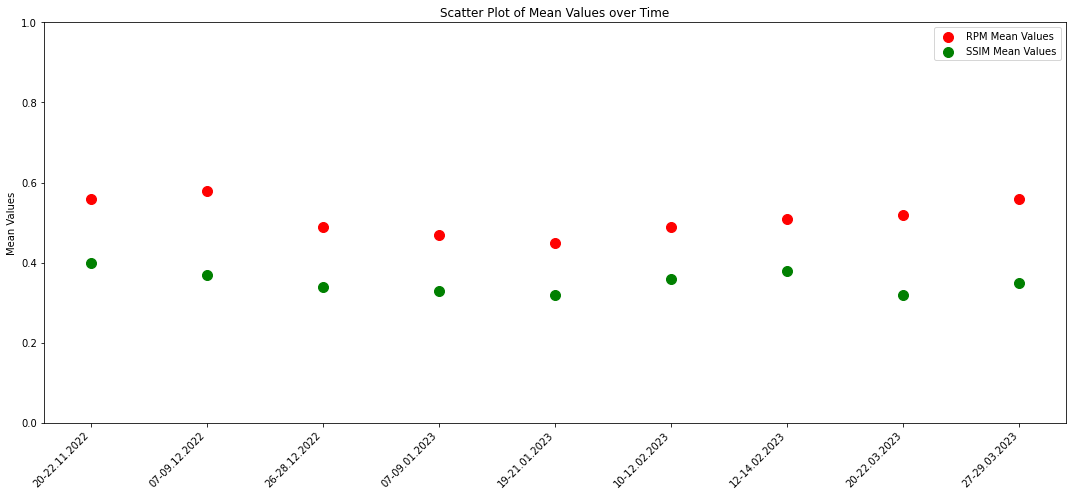

In [28]:
# Create a scatter plot

fig = plt.figure(figsize=(15, 7))  # You can adjust the figure size as needed

# Plot each set of mean values with different colors
plt.scatter(date_labels, sar_rpm_mean, color='red', s=100, label='RPM Mean Values')
plt.scatter(date_labels, sar_ssim_mean, color='green',s=100, label='SSIM Mean Values')

# Set the x-axis to use the tidate labels, rotating them for better readability
plt.xticks(rotation=45, ha='right')

# Set the limits for the y-axis
plt.ylim([0, 1])

# Add labels and title to the plot
#plt.xlabel('Timestamps')
plt.ylabel('Mean Values')
plt.title('Scatter Plot of Mean Values over Time')

# Add a legend
plt.legend()

# Tight layout to ensure everything fits without overlapping
plt.tight_layout()

# Show the plot
plt.show()

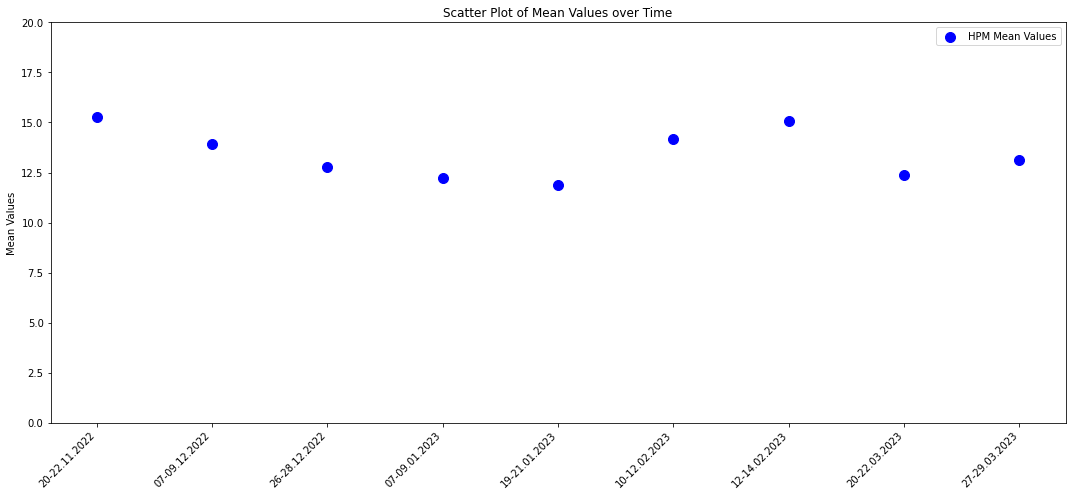

In [32]:
# Create a scatter plot
fig = plt.figure(figsize=(15, 7))  # You can adjust the figure size as needed

# Plot each set of mean values with different colors
plt.scatter(date_labels, sar_hpm_mean, color='blue', s=100, label='HPM Mean Values')

# Set the x-axis to use the tidate labels, rotating them for better readability
plt.xticks(rotation=45, ha='right')

# Set the limits for the y-axis
plt.ylim([0, 20])

# Add labels and title to the plot
#plt.xlabel('Timestamps')
plt.ylabel('Mean Values')
plt.title('Scatter Plot of Mean Values over Time')

# Add a legend
plt.legend()

# Tight layout to ensure everything fits without overlapping
plt.tight_layout()

# Show the plot
plt.show()

## 2 Analysis of error of distortion (corr, hes, ssmi) of Model forecast

In [27]:
mod_dist_folder_name = 'model_distort_error_data'
mod_rpm_list, mod_hpm_list, mod_ssim_list, mod_lon2pm_list, mod_lat2pm_list, mod_gpi1_list, mod_gpi2_list, timestamps = export_distort_data(parent_dir, mod_dist_folder_name)
mod_rpm_mean, mod_rpm_min, mod_rpm_max,  mod_hpm_mean, mod_hpm_min, mod_hpm_max, mod_ssim_mean, mod_ssim_min, mod_ssim_max = calculate_mean_distor_parameters(timestamps, mod_gpi2_list, mod_rpm_list, mod_hpm_list, mod_ssim_list) 

Pair 1:
RPM Mean: 0.45, Min: 0.2, Max: 0.93
HPM Mean: 8.6, Min: -0.58, Max: 29.88
SSIM Mean: 0.27, Min: 0.01, Max: 0.97
--------------------
Pair 2:
RPM Mean: 0.46, Min: 0.2, Max: 0.91
HPM Mean: 6.33, Min: -0.97, Max: 27.37
SSIM Mean: 0.22, Min: 0.01, Max: 0.8
--------------------
Pair 3:
RPM Mean: 0.4, Min: 0.0, Max: 0.9
HPM Mean: 7.25, Min: -0.59, Max: 26.37
SSIM Mean: 0.24, Min: 0.0, Max: 0.7
--------------------
Pair 4:
RPM Mean: 0.43, Min: 0.17, Max: 0.85
HPM Mean: 10.15, Min: -0.12, Max: 26.79
SSIM Mean: 0.3, Min: 0.0, Max: 0.67
--------------------
Pair 5:
RPM Mean: 0.38, Min: 0.0, Max: 0.82
HPM Mean: 7.94, Min: -0.33, Max: 97.42
SSIM Mean: 0.24, Min: 0.0, Max: 0.85
--------------------
Pair 6:
RPM Mean: 0.41, Min: 0.19, Max: 0.74
HPM Mean: 9.46, Min: 0.24, Max: 22.49
SSIM Mean: 0.28, Min: 0.01, Max: 0.62
--------------------
Pair 7:
RPM Mean: 0.45, Min: 0.17, Max: 0.84
HPM Mean: 11.75, Min: 0.18, Max: 32.73
SSIM Mean: 0.33, Min: 0.01, Max: 0.9
--------------------
Pair 8:
RPM M

In [28]:
sar_rpm_mean, sar_hpm_mean, sar_ssim_mean

([0.56, 0.58, 0.49, 0.47, 0.45, 0.49, 0.51, 0.52, 0.56],
 [15.29, 13.93, 12.75, 12.23, 11.87, 14.15, 15.08, 12.38, 13.14],
 [0.4, 0.37, 0.34, 0.33, 0.32, 0.36, 0.38, 0.32, 0.35])

In [29]:
mod_rpm_mean, mod_hpm_mean, mod_ssim_mean

([0.45, 0.46, 0.4, 0.43, 0.38, 0.41, 0.45, 0.49, 0.52],
 [8.6, 6.33, 7.25, 10.15, 7.94, 9.46, 11.75, 10.37, 10.02],
 [0.27, 0.22, 0.24, 0.3, 0.24, 0.28, 0.33, 0.3, 0.31])

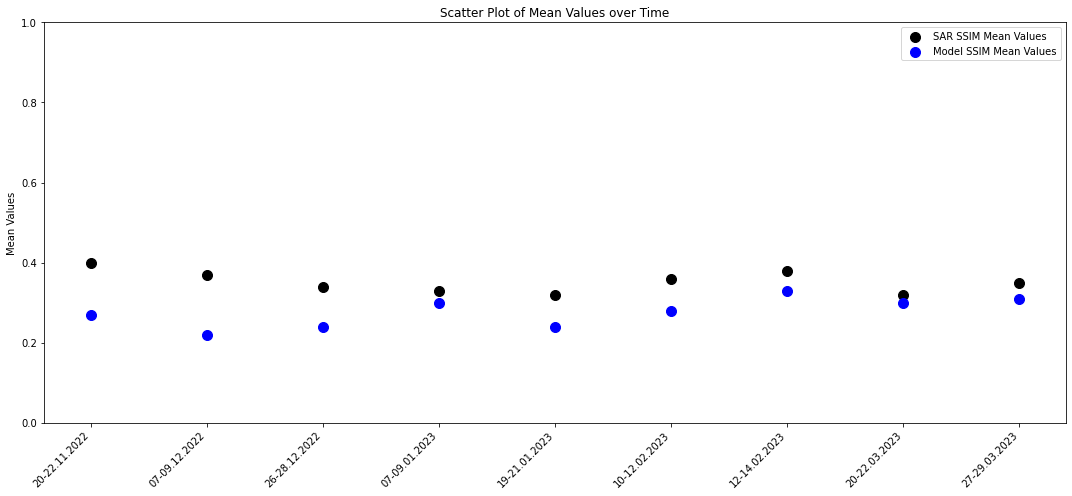

In [33]:
# Create a scatter plot
plt.close(fig)
fig = plt.figure(figsize=(15, 7))  # You can adjust the figure size as needed

# Plot each set of mean values with different colors
#plt.scatter(date_labels, sar_rpm_mean, color='red', s=100, label='SAR RPM Mean Values')
#plt.scatter(date_labels, mod_rpm_mean, color='orange', s=100, label='MOD RPM Mean Values')
plt.scatter(date_labels, sar_ssim_mean, color='black',s=100, label='SAR SSIM Mean Values')
plt.scatter(date_labels, mod_ssim_mean, color='blue',s=100, label='Model SSIM Mean Values')

# Set the x-axis to use the tidate labels, rotating them for better readability
plt.xticks(rotation=45, ha='right')

# Set the limits for the y-axis
plt.ylim([0, 1])

# Add labels and title to the plot
#plt.xlabel('Timestamps')
plt.ylabel('Mean Values')
plt.title('Scatter Plot of Mean Values over Time')

# Add a legend
plt.legend()

# Tight layout to ensure everything fits without overlapping
plt.tight_layout()

#save_plot(save_dir, "SSMI_change_without_gpi")
# Show the plot
plt.show()


In [37]:
# Calculate Relative Root Mean Square Error (RRMSE) for each date
rrmse_list = []

for i in range(len(timestamps)):
    rrmse_values = np.sqrt(((mod_ssim_mean[i] - sar_ssim_mean[i]) ** 2)) / sar_ssim_mean[i]
    rrmse_list.append(rrmse_values)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


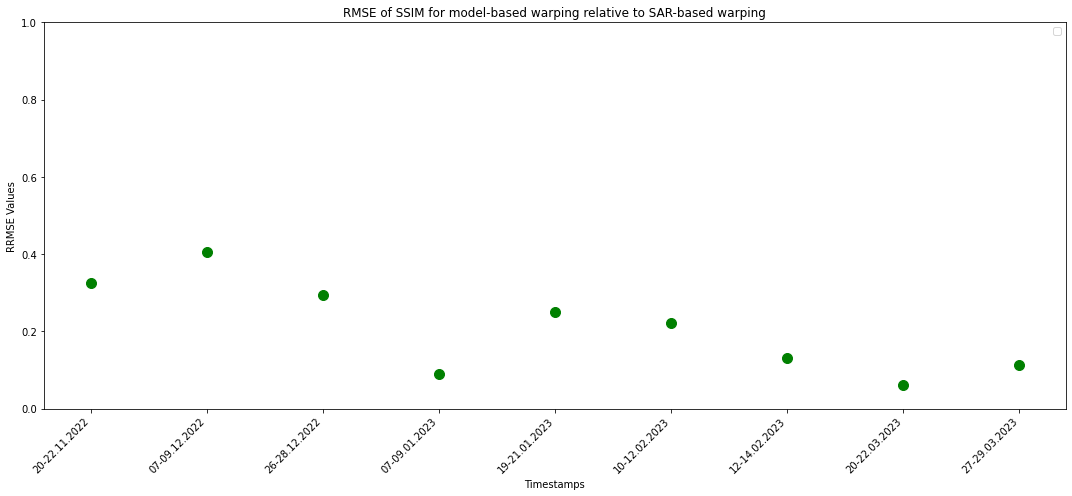

In [38]:
# Create a scatter plot
plt.close('all')  # Close any previously opened plots
fig = plt.figure(figsize=(15, 7))  # You can adjust the figure size as needed

# Plot RRMSE values
plt.scatter(date_labels, rrmse_list, color='green', s=100) #, label='RRMSE of MOD relative to SAR')

# Set the x-axis to use the date labels, rotating them for better readability
plt.xticks(rotation=45, ha='right')

# Since RRMSE can vary, we do not set a fixed y-axis limit as in the previous plot.
plt.ylim([0, 1])  # Adjust the limit based on the max RRMSE value

# Add labels and title to the plot
plt.xlabel('Timestamps')
plt.ylabel('RRMSE Values')
plt.title('RMSE of SSIM for model-based warping relative to SAR-based warping')

# Add a legend
plt.legend()

# Tight layout to ensure everything fits without overlapping
plt.tight_layout()
#save_plot(save_dir, "SSMI_difference")
# Show the plot
plt.show()

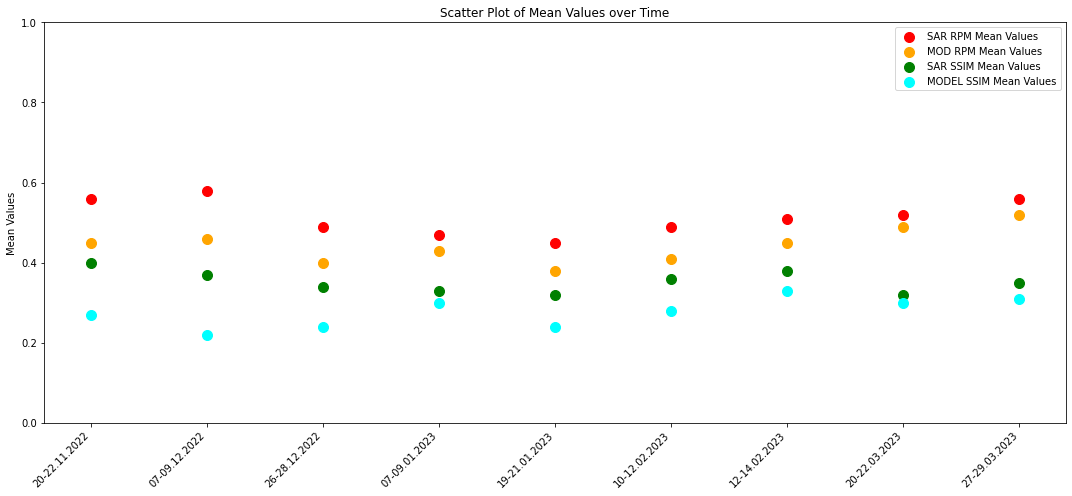

In [39]:
# Create a scatter plot

plt.figure(figsize=(15, 7))  # You can adjust the figure size as needed

# Plot each set of mean values with different colors
plt.scatter(date_labels, sar_rpm_mean, color='red', s=100, label='SAR RPM Mean Values')
plt.scatter(date_labels, mod_rpm_mean, color='orange', s=100, label='MOD RPM Mean Values')
plt.scatter(date_labels, sar_ssim_mean, color='green',s=100, label='SAR SSIM Mean Values')
plt.scatter(date_labels, mod_ssim_mean, color='cyan',s=100, label='MODEL SSIM Mean Values')

# Set the x-axis to use the tidate labels, rotating them for better readability
plt.xticks(rotation=45, ha='right')

# Set the limits for the y-axis
plt.ylim([0, 1])

# Add labels and title to the plot
#plt.xlabel('Timestamps')
plt.ylabel('Mean Values')
plt.title('Scatter Plot of Mean Values over Time')

# Add a legend
plt.legend()

# Tight layout to ensure everything fits without overlapping
plt.tight_layout()

# Show the plot
plt.show()

In [40]:
rpm_dif = sar_rpm_mean-mod_rpm_mean

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [41]:
# Create a scatter plot

plt.figure(figsize=(15, 7))  # You can adjust the figure size as needed

# Plot each set of mean values with different colors
plt.scatter(date_labels, sar_rpm_mean-mod_rpm_mean, color='red', s=100, label='SAR RPM Mean Values')
#plt.scatter(date_labels, mod_rpm_mean-, color='orange', s=100, label='MOD RPM Mean Values')
plt.scatter(date_labels, sar_ssim_mean-mod_ssim_mean, color='green',s=100, label='SAR SSIM Mean Values')
#plt.scatter(date_labels, mod_ssim_mean, color='cyan',s=100, label='MOD SSIM Mean Values')

# Set the x-axis to use the tidate labels, rotating them for better readability
plt.xticks(rotation=45, ha='right')

# Set the limits for the y-axis
plt.ylim([0, 1])

# Add labels and title to the plot
#plt.xlabel('Timestamps')
plt.ylabel('Mean Values')
plt.title('Scatter Plot of Mean Values over Time')

# Add a legend
plt.legend()

# Tight layout to ensure everything fits without overlapping
plt.tight_layout()

# Show the plot
plt.show()

TypeError: unsupported operand type(s) for -: 'list' and 'list'

<Figure size 1080x504 with 0 Axes>

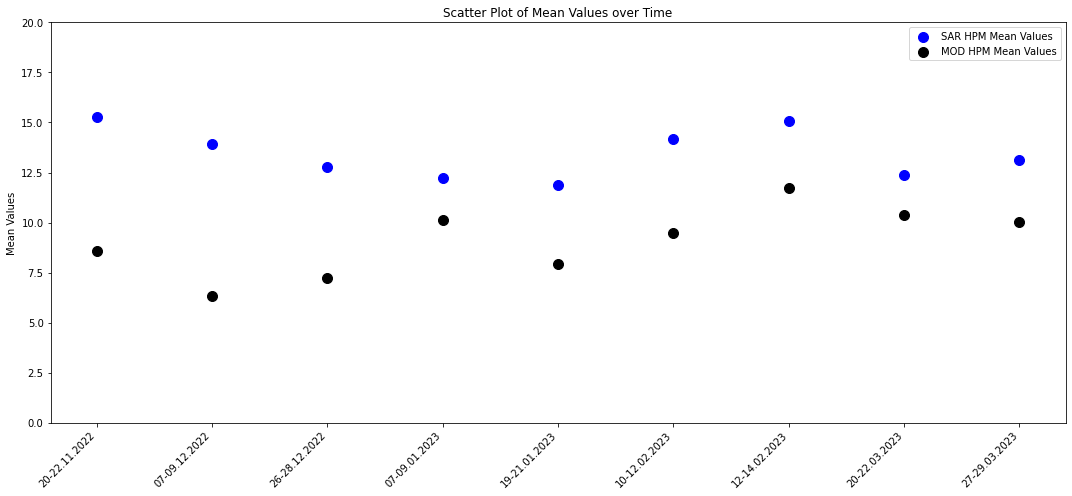

In [42]:

# Create a scatter plot
plt.figure(figsize=(15, 7))  # You can adjust the figure size as needed

# Plot each set of mean values with different colors
plt.scatter(date_labels, sar_hpm_mean, color='blue', s=100, label='SAR HPM Mean Values')
plt.scatter(date_labels, mod_hpm_mean, color='black', s=100, label='MOD HPM Mean Values')

# Set the x-axis to use the tidate labels, rotating them for better readability
plt.xticks(rotation=45, ha='right')

# Set the limits for the y-axis
plt.ylim([0, 20])

# Add labels and title to the plot
#plt.xlabel('Timestamps')
plt.ylabel('Mean Values')
plt.title('Scatter Plot of Mean Values over Time')

# Add a legend
plt.legend()

# Tight layout to ensure everything fits without overlapping
plt.tight_layout()

# Show the plot
plt.show()

## 3. SAR and model drift comparison

### Extracting sar and model displacements

In [10]:
# Exporting drift parametrs (between SAR1 and SAR2)
mod_drift_folder_name = 'mod_drift_output'
mod_drift_variable_names = ['model_u', 'model_v' ]
mod_drift_data, timestamps = export_pm_output_data(parent_dir, mod_drift_folder_name, mod_drift_variable_names)


u_b_list = mod_drift_data['model_u']
v_b_list = mod_drift_data['model_v']


In [11]:
# Replace inf with NaN before calculating the mean
u_sar_list = np.where(np.isinf(u_sar_list), np.nan, u_sar_list)
v_sar_list = np.where(np.isinf(v_sar_list), np.nan, v_sar_list)


### Model total displacement

### Comaprison

In [ ]:
#gpi2_list = sar_gpi2_list

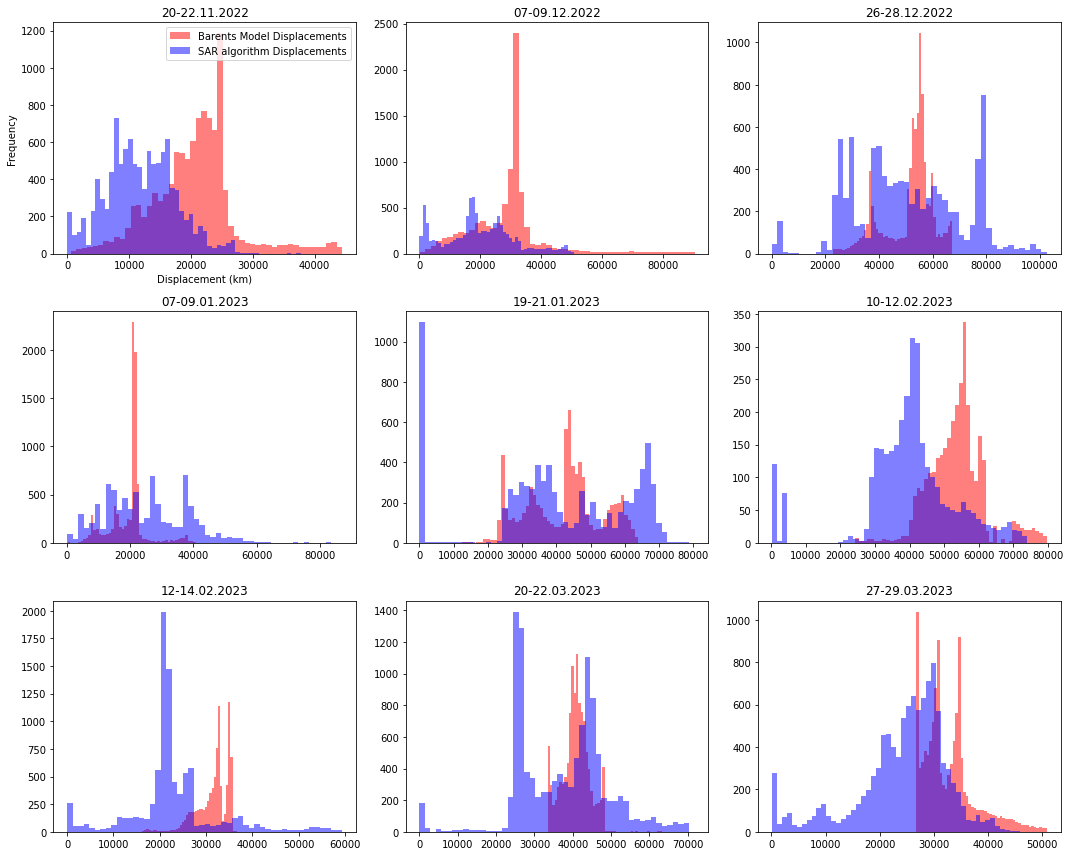

In [12]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 12))  # Adjust the size as needed
axs = axs.flatten()  # Flatten the array of axes for easy iteration

# Loop through all nine datasets
for i, ax in enumerate(axs):
    # Calculate the displacement
    disp_alg = np.sqrt(u_sar_list[i]**2 + v_sar_list[i]**2)
    disp_model_b = np.sqrt(u_b_list[i]**2 + v_b_list[i]**2)
    
    disp_model_b = disp_model_b[gpi2_list[i]].flatten()
    disp_alg = disp_alg[gpi2_list[i]].flatten()


    # Plot histograms
    ax.hist(disp_model_b, bins=50, color='red', alpha=0.5, label='Barents Model Displacements')
    ax.hist(disp_alg, bins=50, color='blue', alpha=0.5, label='SAR algorithm Displacements')

    # Set the title to the corresponding date
    ax.set_title(date_labels[i])

    # Only add labels and legend to the first subplot for clarity
    if i == 0:
        ax.set_xlabel('Displacement (km)')
        ax.set_ylabel('Frequency')
        ax.legend()

# Adjust the layout
plt.tight_layout()


# Show the plot
plt.show()
#save_plot(save_dir, "all_disp_comparison")
plt.close(fig)

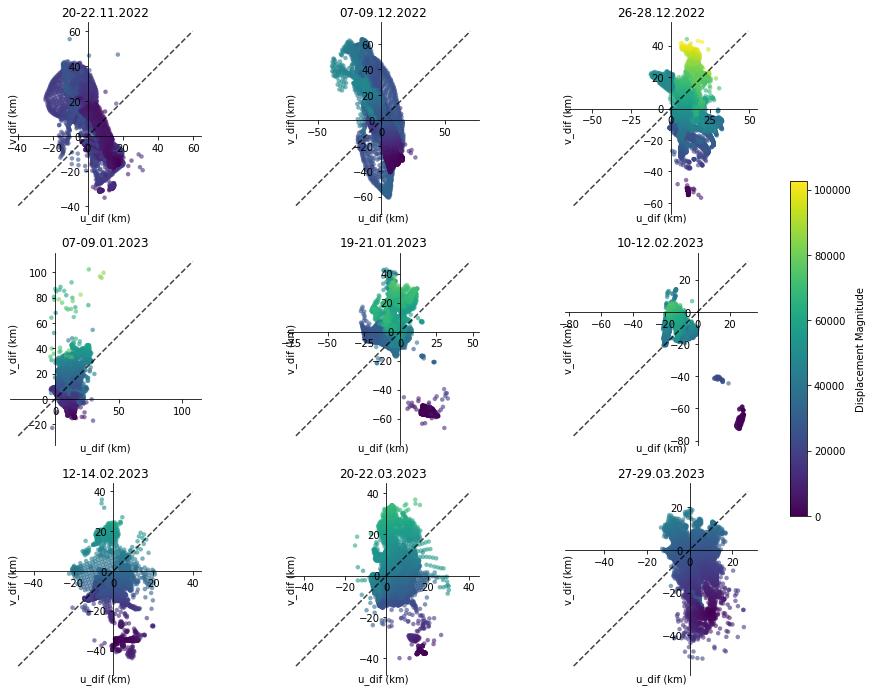

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Example data lists (u_sar_list, v_sar_list, u_b_list, v_b_list, gpi2_list, date_labels) should be defined here

fig, axs = plt.subplots(3, 3, figsize=(15, 12))  # Adjust the size as needed
axs = axs.flatten()  # Flatten the array of axes for easy iteration

# Calculate global range of displacement magnitudes
global_min, global_max = float('inf'), float('-inf')
for i in range(len(u_sar_list)):
    disp_alg = np.sqrt(u_sar_list[i]**2 + v_sar_list[i]**2)
    disp_alg_masked = disp_alg[gpi2_list[i]].flatten()
    global_min = min(global_min, disp_alg_masked.min())
    global_max = max(global_max, disp_alg_masked.max())

# Normalize the color range globally
norm = plt.Normalize(global_min, global_max)

# Creating a ScalarMappable object for the colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])  # You have to set_array for the ScalarMappable

# Loop through all nine datasets
for i, ax in enumerate(axs):
    # Calculate the displacement
    u_dif = u_b_list[i] - u_sar_list[i]
    v_dif = v_b_list[i] - v_sar_list[i]

    # Apply the gpi2 mask and flatten the arrays
    u_dif = u_dif[gpi2_list[i]].flatten()
    v_dif = v_dif[gpi2_list[i]].flatten()

    # Plot scatter plots
    #ax.scatter(u_dif, v_dif, color='red', alpha=0.5, s=15)
    
    # Calculate the absolute total displacement for colours
    disp_alg = np.sqrt(u_sar_list[i]**2 + v_sar_list[i]**2)
    disp_model_b = np.sqrt(u_b_list[i]**2 + v_b_list[i]**2)
    
    # Apply the mask from gpi2_list and flatten the array
    disp_model_b_masked = disp_model_b[gpi2_list[i]].flatten()
    disp_alg_masked = disp_alg[gpi2_list[i]].flatten()
    
    # Generate a color array based on the magnitude of the points
    colors = disp_alg_masked
    
    # Create the scatter plot for the current dataset
    scatter = ax.scatter(u_dif/1000, v_dif/1000, c=colors, cmap='viridis', norm=norm, alpha=0.6, edgecolors='none', s=20)
    
    # Plot a 45-degree line
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k', alpha=0.75, zorder=2, linestyle="--")  # 45 degree line
    ax.set_aspect('equal', 'box')  # ensure aspect ratio is equal
    

    # Move axes to go through (0,0)
    ax.spines['bottom'].set_position('zero')
    ax.spines['left'].set_position('zero')
    
    # Move axis labels outside
    ax.xaxis.set_label_coords(1.05, 0.01)
    ax.yaxis.set_label_coords(0.05, 1.02)

    # Hide top and right spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    

    # Set the title to the corresponding date
    ax.set_title(date_labels[i])
           
    ax.set_xlabel('u_dif (km)')
    ax.set_ylabel('v_dif (km)')
    


    # Only add labels and legend to the first subplot for clarity
    #if i == 0:
        #ax.legend()

# Add the colorbar to the figure
cbar = fig.colorbar(sm, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Displacement Magnitude')

# Adjust the layout
#plt.tight_layout()

# Show the plot
plt.show()

# Uncomment the next line to save the plot
# save_plot(save_dir, "all_disp_comparison")

plt.close(fig)


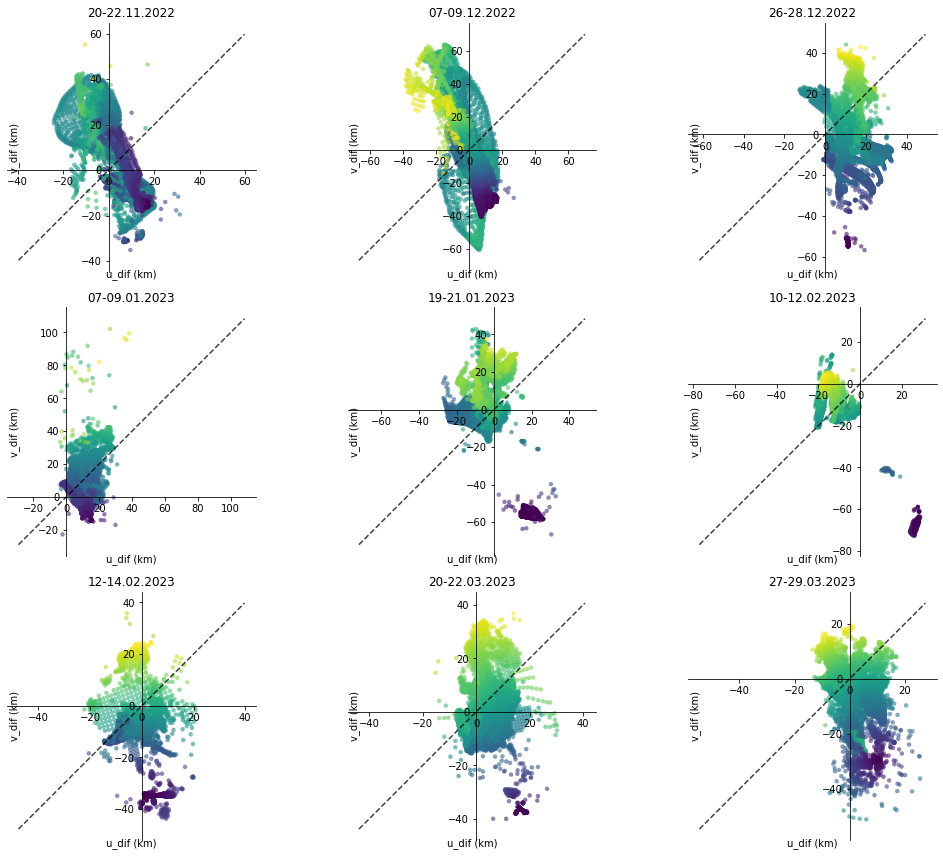

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Example data lists (u_sar_list, v_sar_list, u_b_list, v_b_list, gpi2_list, date_labels) should be defined here

fig, axs = plt.subplots(3, 3, figsize=(15, 12))  # Adjust the size as needed
axs = axs.flatten()  # Flatten the array of axes for easy iteration

# Loop through all nine datasets
for i, ax in enumerate(axs):
    # Calculate the displacement
    u_dif = u_b_list[i] - u_sar_list[i]
    v_dif = v_b_list[i] - v_sar_list[i]

    # Apply the gpi2 mask and flatten the arrays
    u_dif = u_dif[gpi2_list[i]].flatten()
    v_dif = v_dif[gpi2_list[i]].flatten()

    # Plot scatter plots
    #ax.scatter(u_dif, v_dif, color='red', alpha=0.5, s=15)
    
    # Calculate the absolute total displacement for colours
    disp_alg = np.sqrt(u_sar_list[i]**2 + v_sar_list[i]**2)
    disp_model_b = np.sqrt(u_b_list[i]**2 + v_b_list[i]**2)
    
    # Apply the mask from gpi2_list and flatten the array
    disp_model_b_masked = disp_model_b[gpi2_list[i]].flatten()
    disp_alg_masked = disp_alg[gpi2_list[i]].flatten()
    
    # Generate a color array based on the magnitude of the points
    colors = disp_alg_masked
    
    # Create the scatter plot for the current dataset
    scatter = ax.scatter(u_dif/1000, v_dif/1000, c=colors, cmap='viridis', alpha=0.6, edgecolors='none', s=20)
    
    # Plot a 45-degree line
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k', alpha=0.75, zorder=2, linestyle="--")  # 45 degree line
    ax.set_aspect('equal', 'box')  # ensure aspect ratio is equal
    

    # Move axes to go through (0,0)
    ax.spines['bottom'].set_position('zero')
    ax.spines['left'].set_position('zero')
    
    # Move axis labels outside
    ax.xaxis.set_label_coords(1.05, 0.01)
    ax.yaxis.set_label_coords(0.05, 1.02)

    # Hide top and right spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    

    # Set the title to the corresponding date
    ax.set_title(date_labels[i])
           
    ax.set_xlabel('u_dif (km)')
    ax.set_ylabel('v_dif (km)')

    # Only add labels and legend to the first subplot for clarity
    #if i == 0:
        #ax.legend()

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

# Uncomment the next line to save the plot
# save_plot(save_dir, "all_disp_comparison")

plt.close(fig)


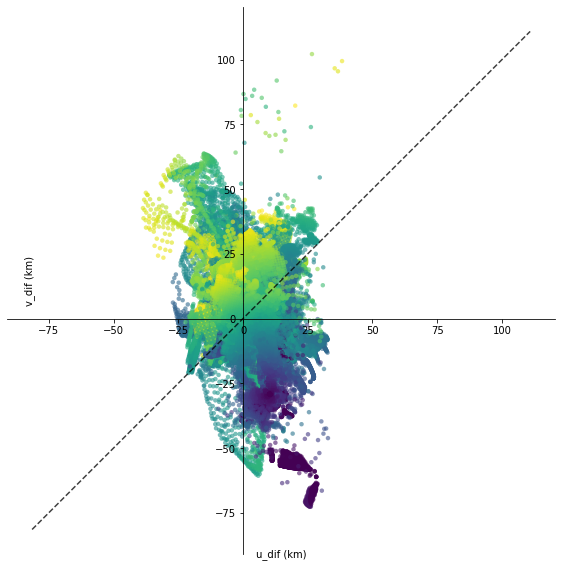

In [174]:
import matplotlib.pyplot as plt
import numpy as np

# Example data lists should be defined here

fig, ax = plt.subplots(figsize=(10, 8))  # Adjust the size as needed

# Loop through all nine datasets
for i in range(len(u_sar_list)):
    # Calculate the displacement differences
    u_dif = (u_b_list[i] - u_sar_list[i])
    v_dif = (v_b_list[i] - v_sar_list[i])

    # Apply the gpi2 mask and flatten the arrays
    u_dif = u_dif[gpi2_list[i]].flatten()
    v_dif = v_dif[gpi2_list[i]].flatten()

    # Calculate the absolute total displacement for colors
    disp_alg = np.sqrt(u_sar_list[i]**2 + v_sar_list[i]**2)
    disp_model_b = np.sqrt(u_b_list[i]**2 + v_b_list[i]**2)

    # Apply the mask from gpi2_list and flatten the array
    disp_model_b_masked = disp_model_b[gpi2_list[i]].flatten()
    disp_alg_masked = disp_alg[gpi2_list[i]].flatten()

    # Generate a color array based on the magnitude of the points
    colors = disp_alg_masked

    # Create the scatter plot for the current dataset
    scatter = ax.scatter(u_dif/1000, v_dif/1000, c=colors, cmap='viridis', alpha=0.6, edgecolors='none', s=20, label=date_labels[i])

# Plot a 45-degree line
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k', alpha=0.75, zorder=2, linestyle="--")  # 45 degree line
ax.set_aspect('equal', 'box')  # ensure aspect ratio is equal

# Move axes to go through (0,0)
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')

# Move axis labels outside
ax.xaxis.set_label_coords(1.05, 0.01)
ax.yaxis.set_label_coords(0.05, 1.02)

# Hide top and right spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel('u_dif (km)')
ax.set_ylabel('v_dif (km)')

# Add legend
#ax.legend()

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

# Uncomment the next line to save the plot
# save_plot(save_dir, "all_disp_comparison")

plt.close(fig)


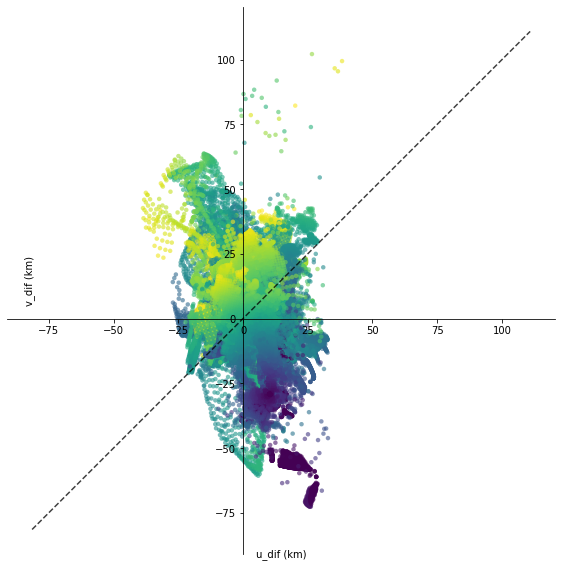

In [175]:
import matplotlib.pyplot as plt
import numpy as np

# Example data lists should be defined here

fig, ax = plt.subplots(figsize=(10, 8))  # Adjust the size as needed

# Loop through all nine datasets
for i in range(len(u_sar_list)):
    # Calculate the displacement differences
    u_dif = u_b_list[i] - u_sar_list[i]
    v_dif = v_b_list[i] - v_sar_list[i]

    # Apply the gpi2 mask and flatten the arrays
    u_dif = u_dif[gpi2_list[i]].flatten()
    v_dif = v_dif[gpi2_list[i]].flatten()

    # Calculate the absolute total displacement for colors
    disp_alg = np.sqrt(u_sar_list[i]**2 + v_sar_list[i]**2)
    disp_model_b = np.sqrt(u_b_list[i]**2 + v_b_list[i]**2)

    # Apply the mask from gpi2_list and flatten the array
    disp_model_b_masked = disp_model_b[gpi2_list[i]].flatten()
    disp_alg_masked = disp_alg[gpi2_list[i]].flatten()

    # Generate a color array based on the magnitude of the points
    colors = disp_alg_masked

    # Create the scatter plot for the current dataset
    scatter = ax.scatter(u_dif/1000, v_dif/1000, c=colors, cmap='viridis', alpha=0.6, edgecolors='none', s=20, label=date_labels[i])

# Plot a 45-degree line
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k', alpha=0.75, zorder=2, linestyle="--")  # 45 degree line
ax.set_aspect('equal', 'box')  # ensure aspect ratio is equal

# Move axes to go through (0,0)
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')

# Move axis labels outside
ax.xaxis.set_label_coords(1.05, 0.01)
ax.yaxis.set_label_coords(0.05, 1.02)

# Hide top and right spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel('u_dif (km)')
ax.set_ylabel('v_dif (km)')

# Add legend
#ax.legend()

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

# Uncomment the next line to save the plot
# save_plot(save_dir, "all_disp_comparison")

plt.close(fig)


In [ ]:
sns.jointplot( x="bill_length_mm", y="bill_depth_mm")

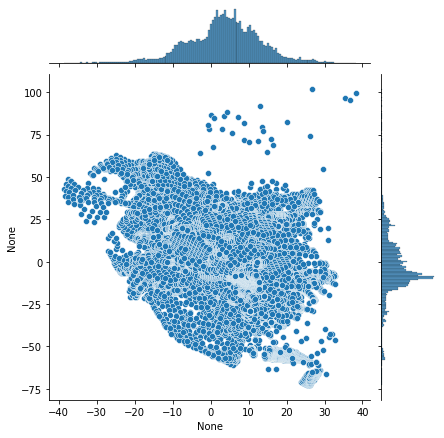

In [159]:
all_u_duf = []
all_v_dif = []
# Generating some synthetic data
for i in range(len(u_sar_list)):
    # Calculate the displacement differences
    u_dif = u_b_list[i]/1000 - u_sar_list[i]/1000
    v_dif = v_b_list[i]/1000 - v_sar_list[i]/1000

    # Apply the gpi2 mask and flatten the arrays
    u_dif = u_dif[gpi2_list[i]].flatten()
    v_dif = v_dif[gpi2_list[i]].flatten()
    
    # Collect the displacements errors
    all_u_duf.extend(u_dif)
    all_v_dif.extend(v_dif)

# Create a jointplot
sns.jointplot(x=all_u_duf, y=all_v_dif, kind =  "scatter")


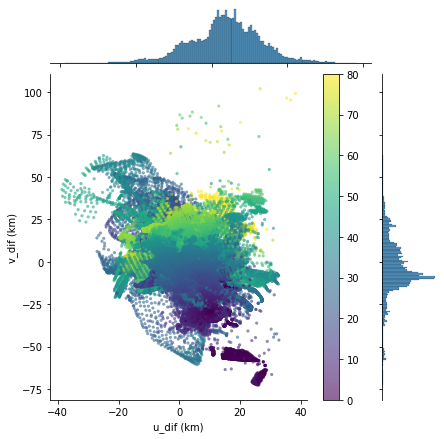

In [200]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example data lists should be defined here

all_u_dif = []
all_v_dif = []
all_disp_mag = []  # Store the displacement magnitudes

# Loop through the datasets
for i in range(len(u_sar_list)):
    # Calculate the displacement differences
    u_dif = u_b_list[i]/1000 - u_sar_list[i]/1000
    v_dif = v_b_list[i]/1000 - v_sar_list[i]/1000

    # Apply the gpi2 mask and flatten the arrays
    u_dif = u_dif[gpi2_list[i]].flatten()
    v_dif = v_dif[gpi2_list[i]].flatten()

    # Calculate the magnitude of sar displacement
    disp_alg = np.sqrt(u_sar_list[i]**2 + v_sar_list[i]**2)

    # Apply the mask from gpi2_list and flatten the array
    disp_mag = disp_alg[gpi2_list[i]].flatten() / 1000  # Converting to km

    # Collect the displacements and their magnitudes
    all_u_dif.extend(u_dif)
    all_v_dif.extend(v_dif)
    all_disp_mag.extend(disp_mag)

# Create a scatter plot using Seaborn's jointplot
joint_plot = sns.jointplot(x=all_u_dif, y=all_v_dif, kind="scatter", alpha=0.6, edgecolor='none', s=10)
# Set the axis labels
joint_plot.set_axis_labels('u_dif (km)', 'v_dif (km)')

# Color each point based on the displacement magnitude
points = joint_plot.ax_joint.collections[0]  # Get the points collection
points.set_cmap('viridis')  # Set the colormap
points.set_norm(plt.Normalize(vmin=np.min(all_disp_mag), vmax=80))  # Normalize with a max value of 80
points.set_array(np.array(all_disp_mag))  # Set the array of values for coloring

# Add a colorbar
plt.colorbar(points, ax=joint_plot.ax_joint)

# Show the plot
plt.show()


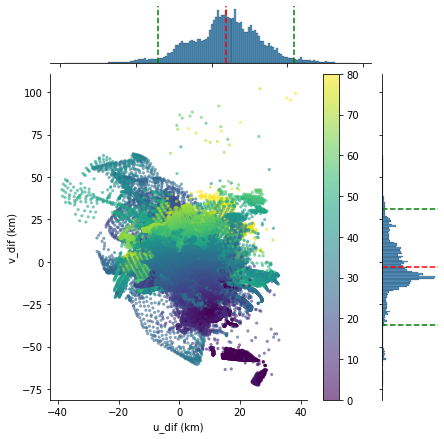

In [204]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example data lists should be defined here

all_u_dif = []
all_v_dif = []
all_disp_mag = []  # Store the displacement magnitudes

# Loop through the datasets
for i in range(len(u_sar_list)):
    # Calculate the displacement differences
    u_dif = u_b_list[i]/1000 - u_sar_list[i]/1000
    v_dif = v_b_list[i]/1000 - v_sar_list[i]/1000

    # Apply the gpi2 mask and flatten the arrays
    u_dif = u_dif[gpi2_list[i]].flatten()
    v_dif = v_dif[gpi2_list[i]].flatten()

    # Calculate the magnitude of sar displacement
    disp_alg = np.sqrt(u_sar_list[i]**2 + v_sar_list[i]**2)

    # Apply the mask from gpi2_list and flatten the array
    disp_mag = disp_alg[gpi2_list[i]].flatten() / 1000  # Converting to km

    # Collect the displacements and their magnitudes
    all_u_dif.extend(u_dif)
    all_v_dif.extend(v_dif)
    all_disp_mag.extend(disp_mag)

# Create a scatter plot using Seaborn's jointplot
joint_plot = sns.jointplot(x=all_u_dif, y=all_v_dif, kind="scatter", alpha=0.6, edgecolor='none', s=10)
# Set the axis labels
joint_plot.set_axis_labels('u_dif (km)', 'v_dif (km)')

# Calculate means and standard deviations
mean_x, std_x = np.mean(all_u_dif), np.std(all_u_dif)
mean_y, std_y = np.mean(all_v_dif), np.std(all_v_dif)

# Add lines for means and ±2 standard deviations on x-axis histogram
joint_plot.ax_marg_x.axvline(mean_x, color='r', linestyle='--')
joint_plot.ax_marg_x.axvline(mean_x - 2*std_x, color='g', linestyle='--')
joint_plot.ax_marg_x.axvline(mean_x + 2*std_x, color='g', linestyle='--')

# Add lines for means and ±2 standard deviations on y-axis histogram
joint_plot.ax_marg_y.axhline(mean_y, color='r', linestyle='--')
joint_plot.ax_marg_y.axhline(mean_y - 2*std_y, color='g', linestyle='--')
joint_plot.ax_marg_y.axhline(mean_y + 2*std_y, color='g', linestyle='--')



# Color each point based on the displacement magnitude
points = joint_plot.ax_joint.collections[0]  # Get the points collection
points.set_cmap('viridis')  # Set the colormap
points.set_norm(plt.Normalize(vmin=np.min(all_disp_mag), vmax=80))  # Normalize with a max value of 80
points.set_array(np.array(all_disp_mag))  # Set the array of values for coloring

# Add a colorbar
plt.colorbar(points, ax=joint_plot.ax_joint)

# Show the plot
plt.show()


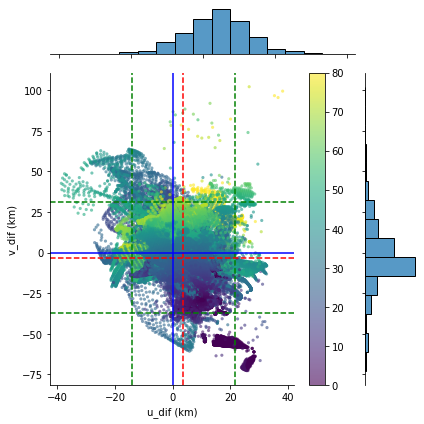

In [211]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example data lists should be defined here

all_u_dif = []
all_v_dif = []
all_disp_mag = []  # Store the displacement magnitudes

# Loop through the datasets
for i in range(len(u_sar_list)):
    # Calculate the displacement differences
    u_dif = u_b_list[i]/1000 - u_sar_list[i]/1000
    v_dif = v_b_list[i]/1000 - v_sar_list[i]/1000

    # Apply the gpi2 mask and flatten the arrays
    u_dif = u_dif[gpi2_list[i]].flatten()
    v_dif = v_dif[gpi2_list[i]].flatten()

    # Calculate the magnitude of sar displacement
    disp_alg = np.sqrt(u_sar_list[i]**2 + v_sar_list[i]**2)

    # Apply the mask from gpi2_list and flatten the array
    disp_mag = disp_alg[gpi2_list[i]].flatten() / 1000  # Converting to km

    # Collect the displacements and their magnitudes
    all_u_dif.extend(u_dif)
    all_v_dif.extend(v_dif)
    all_disp_mag.extend(disp_mag)

# Create a scatter plot using Seaborn's jointplot
joint_plot = sns.jointplot(x=all_u_dif, y=all_v_dif, kind="scatter", alpha=0.6, edgecolor='none', s=10)

# Set the axis labels
joint_plot.set_axis_labels('u_dif (km)', 'v_dif (km)')

# Calculate means and standard deviations
mean_x, std_x = np.mean(all_u_dif), np.std(all_u_dif)
mean_y, std_y = np.mean(all_v_dif), np.std(all_v_dif)

# Add lines for means and ±2 standard deviations on the scatter plot
joint_plot.ax_joint.axvline(mean_x, color='r', linestyle='--')
joint_plot.ax_joint.axvline(mean_x - 2*std_x, color='g', linestyle='--')
joint_plot.ax_joint.axvline(mean_x + 2*std_x, color='g', linestyle='--')
joint_plot.ax_joint.axhline(mean_y, color='r', linestyle='--')
joint_plot.ax_joint.axhline(mean_y - 2*std_y, color='g', linestyle='--')
joint_plot.ax_joint.axhline(mean_y + 2*std_y, color='g', linestyle='--')

# Add two vertical lines intersecting at (0, 0)
joint_plot.ax_joint.axvline(0, color='b', linestyle='-')
joint_plot.ax_joint.axhline(0, color='b', linestyle='-')


# Color each point based on the displacement magnitude
points = joint_plot.ax_joint.collections[0]  # Get the points collection
points.set_cmap('viridis')  # Set the colormap
points.set_norm(plt.Normalize(vmin=np.min(all_disp_mag), vmax=80))  # Normalize with a max value of 80
points.set_array(np.array(all_disp_mag))  # Set the array of values for coloring

# Add a colorbar
plt.colorbar(points, ax=joint_plot.ax_joint)

# Adjust layout for better alignment
plt.tight_layout()

# Show the plot
plt.show()


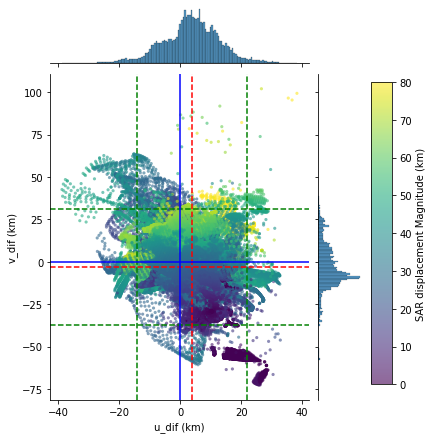

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example data lists should be defined here

all_u_dif = []
all_v_dif = []
all_disp_mag = []  # Store the displacement magnitudes

# Loop through the datasets
for i in range(len(u_sar_list)):
    # Calculate the displacement differences
    u_dif = u_b_list[i]/1000 - u_sar_list[i]/1000
    v_dif = v_b_list[i]/1000 - v_sar_list[i]/1000

    # Apply the gpi2 mask and flatten the arrays
    u_dif = u_dif[gpi2_list[i]].flatten()
    v_dif = v_dif[gpi2_list[i]].flatten()

    # Calculate the magnitude of sar displacement
    disp_alg = np.sqrt(u_sar_list[i]**2 + v_sar_list[i]**2)

    # Apply the mask from gpi2_list and flatten the array
    disp_mag = disp_alg[gpi2_list[i]].flatten() / 1000  # Converting to km

    # Collect the displacements and their magnitudes
    all_u_dif.extend(u_dif)
    all_v_dif.extend(v_dif)
    all_disp_mag.extend(disp_mag)

# Create a scatter plot using Seaborn's jointplot
joint_plot = sns.jointplot(x=all_u_dif, y=all_v_dif, kind="scatter", alpha=0.6, edgecolor='none', s=10)

# Set the axis labels
joint_plot.set_axis_labels('u_dif (km)', 'v_dif (km)')

# Calculate means and standard deviations
mean_x, std_x = np.mean(all_u_dif), np.std(all_u_dif)
mean_y, std_y = np.mean(all_v_dif), np.std(all_v_dif)

# Add lines for means and ±2 standard deviations on the scatter plot
joint_plot.ax_joint.axvline(mean_x, color='r', linestyle='--')
joint_plot.ax_joint.axvline(mean_x - 2*std_x, color='g', linestyle='--')
joint_plot.ax_joint.axvline(mean_x + 2*std_x, color='g', linestyle='--')
joint_plot.ax_joint.axhline(mean_y, color='r', linestyle='--')
joint_plot.ax_joint.axhline(mean_y - 2*std_y, color='g', linestyle='--')
joint_plot.ax_joint.axhline(mean_y + 2*std_y, color='g', linestyle='--')

# Add two vertical lines intersecting at (0, 0)
joint_plot.ax_joint.axvline(0, color='b', linestyle='-')
joint_plot.ax_joint.axhline(0, color='b', linestyle='-')


# Color each point based on the displacement magnitude
points = joint_plot.ax_joint.collections[0]  # Get the points collection
points.set_cmap('viridis')  # Set the colormap
points.set_norm(plt.Normalize(vmin=np.min(all_disp_mag), vmax=80))  # Normalize with a max value of 80
points.set_array(np.array(all_disp_mag))  # Set the array of values for coloring

# Adjust layout to make space for the colorbar
plt.subplots_adjust(right=0.8)

# Add a colorbar to the right of the plot
cbar_ax = joint_plot.fig.add_axes([0.82, 0.1, 0.05, 0.7])  # Adjust these values as needed
cbar = plt.colorbar(points, cax=cbar_ax)
cbar.set_label('SAR displacement Magnitude (km)')

# Adjust layout for better alignment
#plt.tight_layout()

# Show the plot
plt.show()


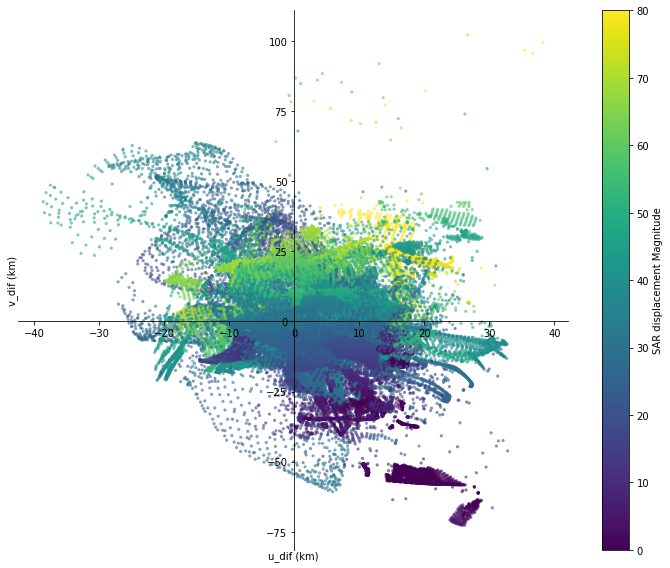

In [233]:
import matplotlib.pyplot as plt
import numpy as np

# Example data lists should be defined here

fig, ax = plt.subplots(figsize=(10, 8))  # Adjust the size as needed

# Initialize arrays to collect data
all_u_dif = []
all_v_dif = []
all_colors = []

# Loop through all nine datasets
for i in range(len(u_sar_list)):
    # Calculate the displacement differences
    u_dif = u_b_list[i]/1000 - u_sar_list[i]/1000
    v_dif = v_b_list[i]/1000 - v_sar_list[i]/1000

    # Apply the gpi2 mask and flatten the arrays
    u_dif_masked = u_dif[gpi2_list[i]].flatten()
    v_dif_masked = v_dif[gpi2_list[i]].flatten()

    # Collect the displacement errors
    all_u_dif.extend(u_dif_masked)
    all_v_dif.extend(v_dif_masked)

    # Calculate the absolute total displacement for colors
    disp_alg = np.sqrt(u_sar_list[i]**2 + v_sar_list[i]**2)
    disp_model_b = np.sqrt(u_b_list[i]**2 + v_b_list[i]**2)

    # Apply the mask from gpi2_list and flatten the array
    disp_alg_masked = disp_alg[gpi2_list[i]].flatten() / 1000  # Converting to km

    # Append to the all_colors array for each dataset
    all_colors.extend(disp_alg_masked)

# Normalize the color range with a maximum value of 80
norm = plt.Normalize(vmin=np.min(all_colors), vmax=80) # vmax=np.max(all_colors))#80)

# Create the scatter plot for the combined dataset
scatter = ax.scatter(all_u_dif, all_v_dif, c=all_colors, cmap='viridis', norm=norm, alpha=0.6, edgecolors='none', s=10)

'''
# Plot a 45-degree line
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k', alpha=0.75, zorder=1, linestyle="--")  # 45 degree line
ax.set_aspect('equal', 'box')  # ensure aspect ratio is equal
'''

# Move axes to go through (0,0) and adjust labels
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.xaxis.set_label_coords(1, 0)
ax.yaxis.set_label_coords(0, 1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('u_dif (km)')
ax.set_ylabel('v_dif (km)')

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=np.min(all_colors),vmax=80))#vmax = np.max(all_colors))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('SAR displacement Magnitude')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

# Close the figure
plt.close(fig)


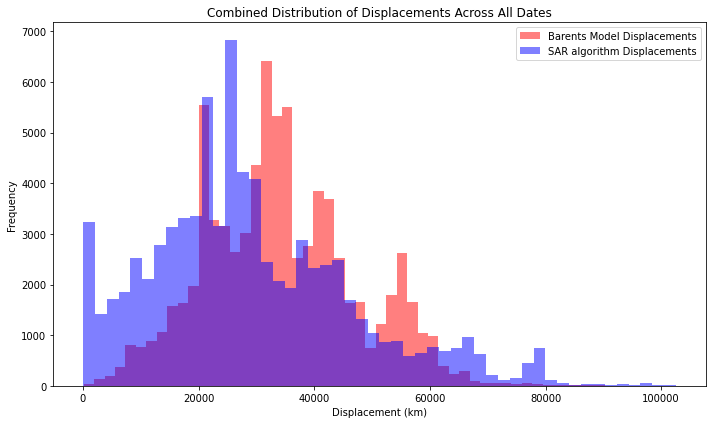

In [87]:
# Initialize a list to collect all displacements
all_disp_alg = []
all_disp_model_b = []

# Loop through all nine datasets
for i in range(9):
    # Calculate the displacement
    disp_alg = np.sqrt(u_sar_list[i]**2 + v_sar_list[i]**2)
    disp_model_b = np.sqrt(u_b_list[i]**2 + v_b_list[i]**2)
    
    # Apply the mask from gpi2_list and flatten the array
    disp_model_b = disp_model_b[gpi2_list[i]].flatten()
    disp_alg = disp_alg[gpi2_list[i]].flatten()

    # Collect the displacements
    all_disp_alg.extend(disp_alg)
    all_disp_model_b.extend(disp_model_b)

fig, axs = plt.subplots(1, 1, figsize=(10, 6))
# Plot the combined histograms
plt.hist(all_disp_model_b, bins=50, color='red', alpha=0.5, label='Barents Model Displacements')
plt.hist(all_disp_alg, bins=50, color='blue', alpha=0.5, label='SAR algorithm Displacements')

# Add labels and legend
plt.xlabel('Displacement (km)')
plt.ylabel('Frequency')
plt.title('Combined Distribution of Displacements Across All Dates')
plt.legend()

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()
#save_plot(save_dir, "all_disp_in_one_hist_comparison")
plt.close(fig)

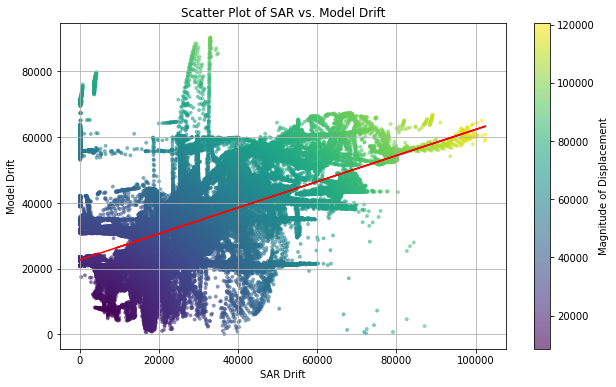

In [73]:
# Initialize empty lists to collect all displacements
all_disp_alg = []
all_disp_model_b = []

# Assuming u_sar_list, v_sar_list, u_b_list, v_b_list, and gpi2_list are defined
# Loop through all datasets and collect displacements
for i in range(9):
    # Your existing code for calculating displacements goes here
    
    # Calculate the displacement
    disp_alg = np.sqrt(u_sar_list[i]**2 + v_sar_list[i]**2)
    disp_model_b = np.sqrt(u_b_list[i]**2 + v_b_list[i]**2)
    
    # Apply the mask from gpi2_list and flatten the array
    disp_model_b = disp_model_b[gpi2_list[i]].flatten()
    disp_alg = disp_alg[gpi2_list[i]].flatten()

    # Collect the displacements
    all_disp_alg.extend(disp_alg)
    all_disp_model_b.extend(disp_model_b)

# Convert the lists to NumPy arrays
all_disp_alg = np.array(all_disp_alg)
all_disp_model_b = np.array(all_disp_model_b)

# Now create the scatter plot
fig, ax = plt.subplots(figsize=(10, 6))

# Generate a color array based on the magnitude of the points
colors = np.sqrt(all_disp_alg**2 + all_disp_model_b**2)
scatter = ax.scatter(all_disp_alg, all_disp_model_b, c=colors, cmap='viridis', alpha=0.6, edgecolors='none', s=15)

# Compute a line of best fit
m, b = np.polyfit(all_disp_alg, all_disp_model_b, 1)
# Plot the line of best fit using the NumPy arrays
ax.plot(all_disp_alg, m * all_disp_alg + b, color='red')

# Add labels and title
ax.set_xlabel('SAR Drift')
ax.set_ylabel('Model Drift')
ax.set_title('Scatter Plot of SAR vs. Model Drift')

# Create a colorbar legend
cbar = plt.colorbar(scatter)
cbar.set_label('Magnitude of Displacement')

# Show grid
plt.grid(True)

# Display the plot
plt.show()
#save_plot(save_dir, "Disp_comparison_scatter_plot")
plt.close(fig)

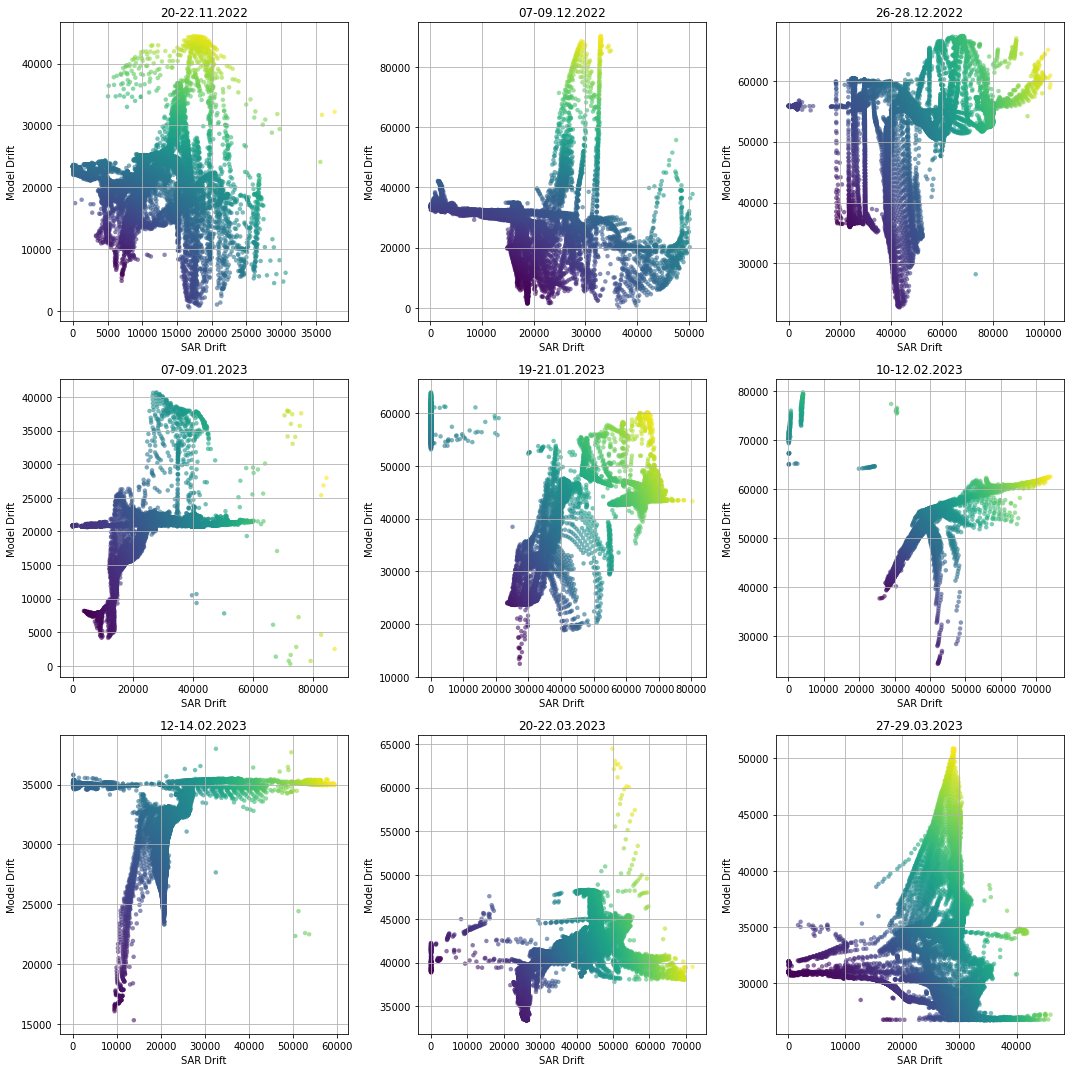

In [76]:
# Initialize a figure with 9 subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # Adjusted for 9 subplots
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

# Loop through all datasets and create scatter plots for each
for i in range(9):
    # Calculate the displacement
    disp_alg = np.sqrt(u_sar_list[i]**2 + v_sar_list[i]**2)
    disp_model_b = np.sqrt(u_b_list[i]**2 + v_b_list[i]**2)
    
    # Apply the mask from gpi2_list and flatten the array
    disp_model_b_masked = disp_model_b[gpi2_list[i]].flatten()
    disp_alg_masked = disp_alg[gpi2_list[i]].flatten()

    # Generate a color array based on the magnitude of the points
    colors = np.sqrt(disp_alg_masked**2 + disp_model_b_masked**2)
    
    # Create the scatter plot for the current dataset
    scatter = axes[i].scatter(disp_alg_masked, disp_model_b_masked, c=colors, cmap='viridis', alpha=0.6, edgecolors='none', s=20)
    

    # Set labels and titles for each subplot
    axes[i].set_xlabel('SAR Drift')
    axes[i].set_ylabel('Model Drift')
    axes[i].set_title(f'{date_labels[i]}')
    axes[i].grid(True)

# Adjust layout to prevent overlap
fig.tight_layout()

#save_plot(save_dir, "disp_comparison_9")
# Show the plot
plt.show()

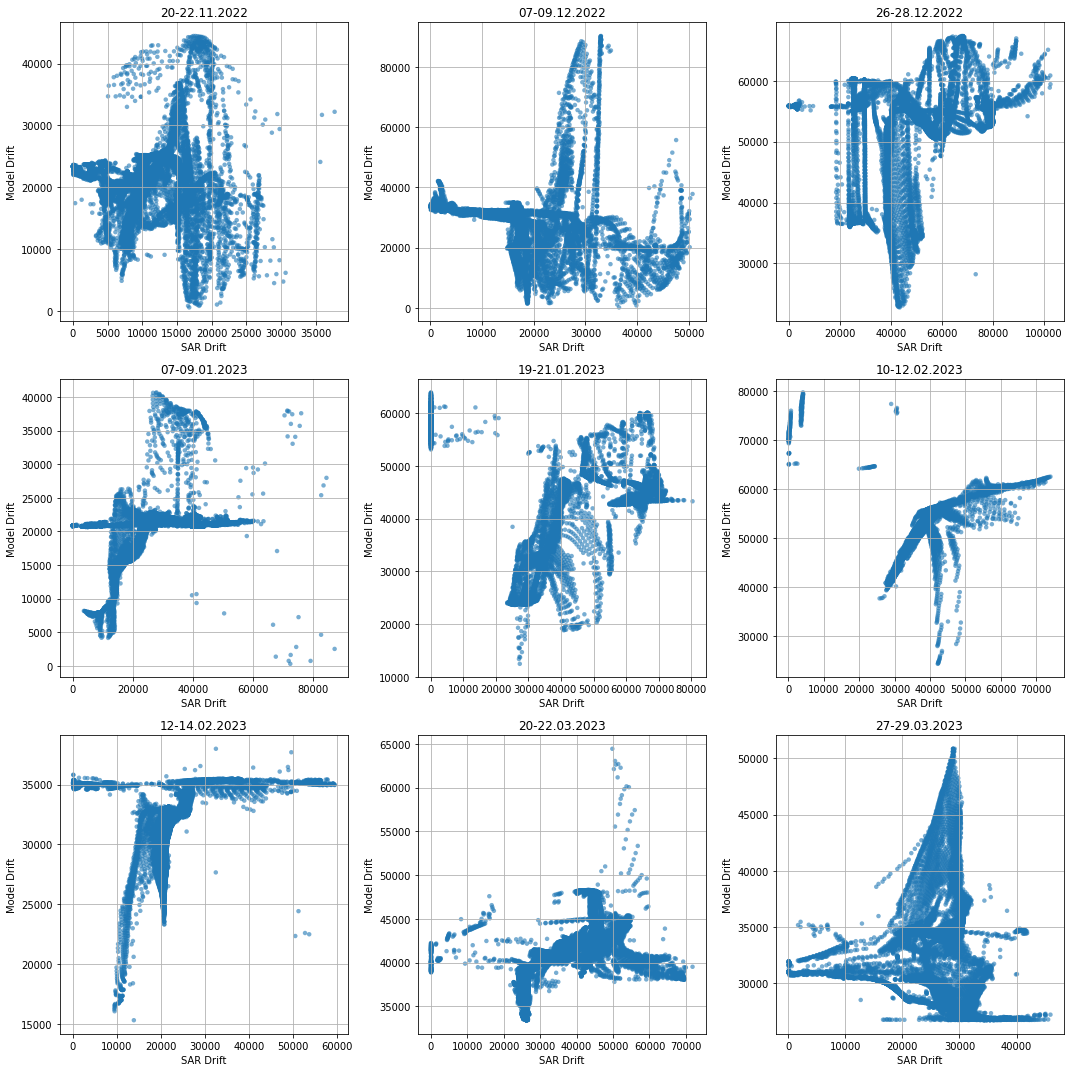

In [75]:
# Re-initialize the figure with 9 subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # Adjusted for 9 subplots
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

# Loop through all datasets and create scatter plots for each
for i in range(9):
    # Calculate the displacement
    disp_alg = np.sqrt(u_sar_list[i]**2 + v_sar_list[i]**2)
    disp_model_b = np.sqrt(u_b_list[i]**2 + v_b_list[i]**2)
    
    # Apply the mask from gpi2_list and flatten the array
    disp_model_b_masked = disp_model_b[gpi2_list[i]].flatten()
    disp_alg_masked = disp_alg[gpi2_list[i]].flatten()

    # Create the scatter plot for the current dataset without a line of best fit
    axes[i].scatter(disp_alg_masked, disp_model_b_masked, alpha=0.6, edgecolors='none', s=20)

    # Set labels and titles for each subplot
    axes[i].set_xlabel('SAR Drift')
    axes[i].set_ylabel('Model Drift')
    axes[i].set_title(f'{date_labels[i]}')
    axes[i].grid(True)

# Adjust layout to prevent overlap
fig.tight_layout()
#save_plot(save_dir, "disp_comparison_9")
# Show the plot
plt.show()


TypeError: unsupported operand type(s) for ** or pow(): 'list' and 'int'

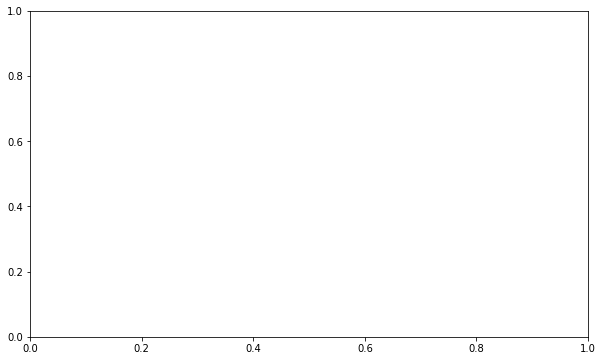

In [118]:
# Create scatter plot with points colored according to their value (from low to high)
for i in range(9):
    # Calculate the displacement
    disp_alg = np.sqrt(u_sar_list[i]**2 + v_sar_list[i]**2)
    disp_model_b = np.sqrt(u_b_list[i]**2 + v_b_list[i]**2)
    
    # Apply the mask from gpi2_list and flatten the array
    disp_model_b = disp_model_b[gpi2_list[i]].flatten()
    disp_alg = disp_alg[gpi2_list[i]].flatten()

    # Collect the displacements
    all_disp_alg.extend(disp_alg)
    all_disp_model_b.extend(disp_model_b)

fig, ax = plt.subplots(figsize=(10, 6))

# Generate a color array based on the magnitude of the points
colors = np.sqrt(all_disp_alg**2 + all_disp_model_b**2)
scatter = ax.scatter(all_disp_alg, all_disp_model_b, c=colors, cmap='viridis', alpha=0.6, edgecolors='none', s=80)

# Compute a line of best fit
m, b = np.polyfit(all_disp_alg, all_disp_model_b, 1)
# Plot the line of best fit using the NumPy arrays
ax.plot(all_disp_alg, m * all_disp_alg + b, color='red')

# Add labels and title
ax.set_xlabel('SAR Drift')
ax.set_ylabel('Model Drift')
ax.set_title('Scatter Plot of SAR vs. Model Drift')

# Create a colorbar legend
cbar = plt.colorbar(scatter)
cbar.set_label('Magnitude of Displacement')

# Show grid
plt.grid(True)

# Display the plot
plt.show()

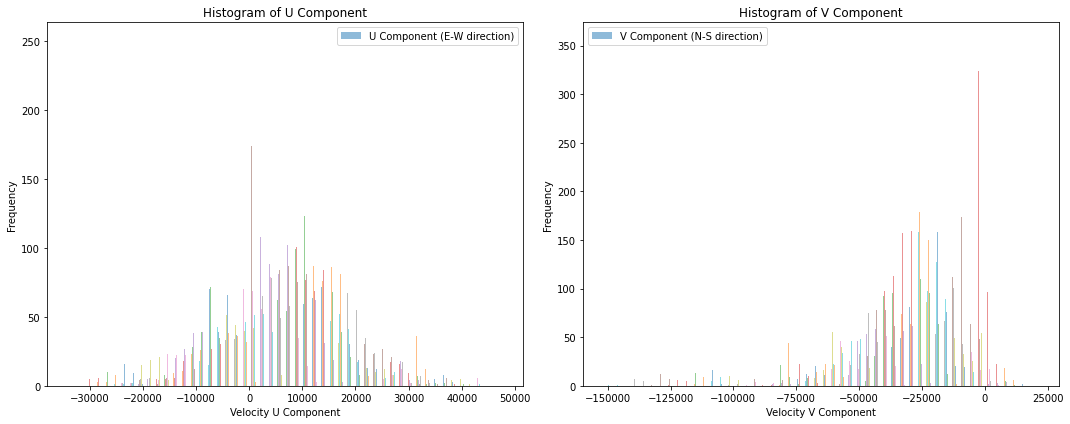

In [52]:
import matplotlib.pyplot as plt
import numpy as np


# Flatten the lists to get combined histograms for all datasets
u_all = np.concatenate(u_sar_list)
v_all = np.concatenate(v_sar_list)

# Plot histograms for u and v components
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.hist(u_all, bins=50, alpha=0.5, label='U Component (E-W direction)')
plt.xlabel('Velocity U Component')
plt.ylabel('Frequency')
plt.title('Histogram of U Component')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(v_all, bins=50, alpha=0.5, label='V Component (N-S direction)')
plt.xlabel('Velocity V Component')
plt.ylabel('Frequency')
plt.title('Histogram of V Component')
plt.legend()

plt.tight_layout()
plt.show()


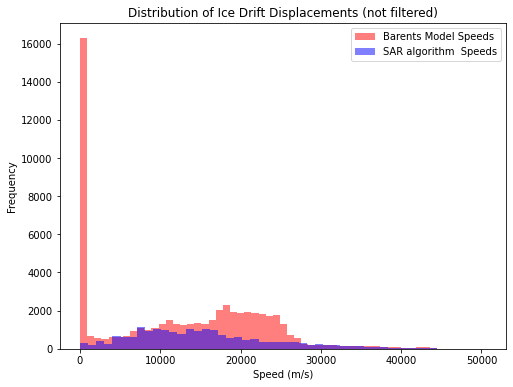

In [49]:
disp_model_b = np.sqrt(( model_u**2+ model_v**2)) 
disp_alg = np.sqrt((upm_list_no_inf**2+ vpm_list_no_inf**2))

disp_model_b = disp_model_b.flatten()
disp_alg = disp_alg.flatten()


plt.figure(figsize=(8,6))


# Plotting Model Speed
plt.hist(disp_model_b, bins=50, color='red', alpha=0.5, label= 'Barents Model Speeds')

# Plotting Reference Speed
plt.hist(disp_alg, bins=50, color='blue', alpha=0.5, label='SAR algorithm  Speeds')

plt.xlabel('Speed (m/s)')
plt.ylabel('Frequency')
plt.title('Distribution of Ice Drift Displacements (not filtered)')
plt.legend()
plt.show()



In [95]:
u_sar_list[6], v_sar_list[6], u_b_list[6], v_b_list[6], date_labels[6]

(array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 array([[-8.04480526e+03, -8.04957451e+03, -8.05630690e+03, ...,
         -2.60923933e+04, -2.52419010e+04, -2.46050690e+04],
        [-7.98051781e+03, -7.98416553e+03, -7.98980035e+03, ...,
         -2.80148915e+04, -2.69326256e+04, -2.60729891e+04],
        [-7.91635804e+03, -7.91916895e+03, -7.92311991e+03, ...,
         -3.04500782e+04, -2.89644242e+04, -2.78478583e+04],
        ...,
        [ 4.02439419e+01,  3.37517506e+

In [110]:
i = 1
date_labels[i]

'07-09.12.2022'

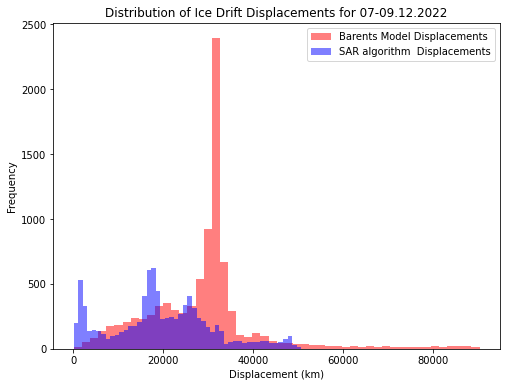

Reference disp:
Mean disp: 19.7 km
Min disp: 0.1 km
Max disp: 50.7 km
95th percentile disp: 41902.5201 km

Model disp:
Mean disp: 29.0 km
Min disp: 0.1 km
Max disp: 90.3 km
95th percentile disp: 50051.6363 km


In [111]:
i = 1

disp_model_b = np.sqrt((  u_b_list[i]**2+ v_b_list[i]**2)) 
disp_alg = np.sqrt((u_sar_list[i]**2+ v_sar_list[i]**2))

disp_model_b = disp_model_b[gpi2_list[i]].flatten()
disp_alg = disp_alg[gpi2_list[i]].flatten()

fig = plt.figure(figsize=(8,6))

# Plotting Model displacements
plt.hist(disp_model_b, bins=50, color='red', alpha=0.5, label= 'Barents Model Displacements')

# Plotting Reference displacement
plt.hist(disp_alg, bins=50, color='blue', alpha=0.5, label='SAR algorithm  Displacements')

plt.xlabel('Displacement (km)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Ice Drift Displacements for {date_labels[i]}')
plt.legend()

# Save plot
plt.savefig("/home/jovyan/experiment_data/2022-2023_48h_experiment/figures/drift_comparison_hist.png", dpi=300, bbox_inches='tight')


plt.show()
#save_plot(save_dir, f"disp_dif_for_{date_labels[i]}")
plt.close(fig)

# Print statistics for reference displacements
percentile_95_ref = np.percentile(disp_alg, 95)
mean_disp_ref = np.nanmean(disp_alg)
min_disp_ref = np.nanmin(disp_alg)
max_disp_ref = np.nanmax(disp_alg)

print(f"Reference disp:")
print(f"Mean disp: {mean_disp_ref/1000:.1f} km")
print(f"Min disp: {min_disp_ref/1000:.1f} km")
print(f"Max disp: {max_disp_ref/1000:.1f} km")
print(f"95th percentile disp: {percentile_95_ref:.4f} km")

# Print statistics for model displacements
percentile_95_model = np.percentile(disp_model_b, 95)
mean_disp_model = np.nanmean(disp_model_b)
min_disp_model = np.nanmin(disp_model_b)
max_disp_model = np.nanmax(disp_model_b)

print("\nModel disp:")
print(f"Mean disp: {mean_disp_model/1000:.1f} km")
print(f"Min disp: {min_disp_model/1000:.1f} km")
print(f"Max disp: {max_disp_model/1000:.1f} km")
print(f"95th percentile disp: {percentile_95_model:.4f} km")
